# Generative Adversarial Network

Jun Zhu

---

This notebook was modified from the Deep Learning Foundation Project at Udacity. **It is simply used to demonstrate how a GAN works.**

In this notebook, we'll be build a generative adversarial network (GAN) trained on the MNIST dataset. From this, we'll be able to generate new handwritten digits!

GANs were [first reported on](https://arxiv.org/abs/1406.2661) in 2014 from Ian Goodfellow and others in Yoshua Bengio's lab. Since then, GANs have exploded in popularity. Here are a few examples to check out:

* [Pix2Pix](https://affinelayer.com/pixsrv/) 
* [CycleGAN](https://github.com/junyanz/CycleGAN)
* [A whole list](https://github.com/wiseodd/generative-models)

The idea behind GANs is that you have two networks, a generator $G$ and a discriminator $D$, competing against each other. The generator makes fake data to pass to the discriminator. The discriminator also sees real data and predicts if the data it's received is real or fake. The generator is trained to fool the discriminator, it wants to output data that looks _as close as possible_ to real data. And the discriminator is trained to figure out which data is real and which is fake. What ends up happening is that the generator learns to make data that is indistiguishable from real data to the discriminator.

![GAN diagram](images/gan_diagram.png)

The general structure of a GAN is shown in the diagram above, using MNIST images as data. The **latent sample** is a random vector the generator uses to contruct it's fake images. As the generator learns through training, it figures out how to map these random vectors to recognizable images that can fool the discriminator.

The output of the discriminator is a sigmoid function, where 0 indicates a fake image and 1 indicates an real image. If you're interested only in generating new images, you can throw out the discriminator after training. Now, let's see how we build this thing in TensorFlow.

In [1]:
%matplotlib inline

import os
import random
import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Download and visualize data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

print("Shape of the training data: {}".format(mnist.train.images.shape))
print("Shape of the testing data: {}".format(mnist.test.images.shape))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Shape of the training data: (55000, 784)
Shape of the testing data: (10000, 784)


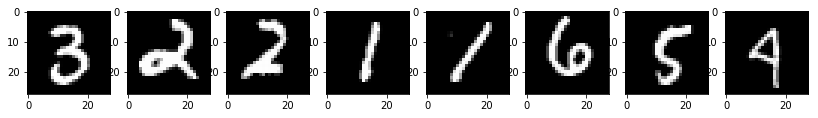

In [3]:
fig, axes = plt.subplots(1, 8, figsize=(14, 1.6))
for ax in axes:
    img = mnist.train.images[random.randint(0, len(mnist.train.images))]
    ax.imshow(img.reshape(28, 28), cmap="gray")

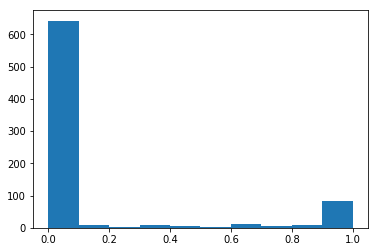

In [4]:
# The data values are in the range of [0, 1]
img = mnist.train.images[random.randint(0, len(mnist.train.images))]
_ = plt.hist(img)

## Generator network

![GAN Network](images/gan_network.png)

Here we'll build the generator network. **We should use a leaky ReLU to allow gradients to flow backwards through the layer unimpeded**. The leaky ReLU is defined as

$$
f(x) = max(\alpha * x, x)
$$

In [5]:
def model_inputs(real_size, z_size):
    """Create two inputs for the discriminator and generator respectively
    
    :param real_size: int
        Length of the flattened image data.
    :param z_dim: int
        Length of the input vector for the generator.
    
    :return: (input_real, input_z)
    """
    inputs_real = tf.placeholder(tf.float32, (None, real_size), name="input_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_size), name="input_z")
    
    return inputs_real, inputs_z

#### Variable Scope
Here we need to use `tf.variable_scope` for two reasons. Firstly, we're going to make sure all the variable names start with `generator`. Similarly, we'll prepend `discriminator` to the discriminator variables. This will help out later when we're training the separate networks.

We could just use `tf.name_scope` to set the names, but we also want to reuse these networks with different inputs. For the generator, we're going to train it, but also _sample from it_ as we're training and after training. The discriminator will need to share variables between the fake and real input images. So, we can use the `reuse` keyword for `tf.variable_scope` to tell TensorFlow to reuse the variables instead of creating new ones if we build the graph again.

#### Tanh Output
The generator has been found to perform the best with $tanh$ for the generator output. This means that **we'll have to rescale the MNIST images to be between -1 and 1**.

In [6]:
def generator(z, real_size, reuse=False):
    """Build the generator network.
    
    :param z : latent sample
    :param real_size : Size of the real data
    :param reuse : Reuse the variables with tf.variable_scope

    :return: output 
    """
    with tf.variable_scope('generator', reuse=reuse):
        # Hidden layer
        h1 = tf.layers.dense(z, 100, activation=tf.nn.relu)
        
        # Logits with tanh output
        output = tf.layers.dense(h1, real_size, activation=tf.tanh)
        
        return output

## Discriminator

Note that we use sigmoid activation for the output layer.

In [7]:
def discriminator(x, reuse=False, alpha=0.01):
    """Build the discriminator network.
    
    :param x : real or fake data
    :param reuse : Reuse the variables with tf.variable_scope
    :param alpha : leak parameter for leaky ReLU

    :return out:
    :return logits: 
    """
    leaky_relu = lambda x : tf.maximum(alpha*x, x)
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer
        h1 = tf.layers.dense(x, 100, activation=leaky_relu)
        
        logits = tf.layers.dense(h1, 1, activation=None)
        output = tf.sigmoid(logits)
        
        return output, logits

## Hyperparameters

In [8]:
real_size = 784  # 28x28 MNIST images flattened

z_size = 100  # Size of latent sample

alpha = 0.1  # Leak factor for leaky ReLU

smooth = 0.1  # Label smoothing 

## Build network

We'll build two discriminators, one for real data and one for fake data. **Since we want the weights to be the same for both real and fake data, we need to reuse the variables**. For the fake data, we're getting it from the generator as `g_model`. So the real data discriminator is `discriminator(input_real)` while the fake discriminator is `discriminator(g_model, reuse=True)`.

In [9]:
tf.reset_default_graph()
# Create our input placeholders
inputs_real, inputs_z = model_inputs(real_size, z_size)

# Generator network here
g_model = generator(inputs_z, real_size)

# Disriminator network here
d_model_real, d_logits_real = discriminator(inputs_real, reuse=False, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

## Discriminator and Generator Losses

<img src="images/two_phase_training.png" style="width:800px;">
<caption> <u> **Figure 1** </u>: Two-phase training procedure of a basic GAN network. This paragraph explains why we need the two-phase training process: 1. k steps for training the discriminator (**Maximize D**); 2. one step for training the generator (**Minimize G**). At the beginning of the training, as this paragraph explains, phase-1 has little effect. The learning mainly takes place in phase 2.<br> </caption>

For the real image logits, we'll use `d_logits_real` which we got from the discriminator in the cell above. For the labels, we want them to be all ones, since these are all real images. To help the discriminator generalize better, the labels are reduced a bit from 1.0 to 0.9, for example,  using the parameter `smooth`. This is known as **label smoothing**, typically used with classifiers to improve performance. In TensorFlow, it looks something like `labels = tf.ones_like(tensor) * (1 - smooth)`

In [10]:
# Calculate losses

# Maximize D
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - smooth)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=d_logits_fake, labels=tf.zeros_like(d_logits_real)))
d_loss = d_loss_real + d_loss_fake

# Minimize G
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

## Training

We want to update the generator and discriminator variables separately. So we need to get the variables for each part and build optimizers for the two parts. To get all the trainable variables, we use `tf.trainable_variables()`. This creates a list of all the variables we've defined in our graph.

For the generator optimizer, we only want to generator variables. Our past selves were nice and used a variable scope to start all of our generator variable names with `generator`. So, we just need to iterate through the list from `tf.trainable_variables()` and keep variables that start with `generator`. Each variable object has an attribute `name` which holds the name of the variable as a string (`var.name == 'weights_0'` for instance). 

We can do something similar with the discriminator. All the variables in the discriminator start with `discriminator`.

Then, in the optimizer we pass the variable lists to the `var_list` keyword argument of the `minimize` method. This tells the optimizer to only update the listed variables. Something like `tf.train.AdamOptimizer().minimize(loss, var_list=var_list)` will only train the variables in `var_list`.

In [11]:
k = 2
batch_size = 128
epochs = 1000
fake_data = []
losses = []
learning_rate = 0.0005

# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

saver = tf.train.Saver(var_list=g_vars)

with tf.Session() as sess:

    if not os.path.exists('./checkpoints/generator.ckpt'):
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            num_batches = mnist.train.num_examples//batch_size
            for ii in range(num_batches):
                batch = mnist.train.next_batch(batch_size)

                # Get images, reshape and rescale to pass to D
                batch_images = batch[0].reshape((batch_size, 784))
                batch_images = batch_images*2 - 1  # normalize to [-1, 1] 

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
                # train the discriminator
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z})
               
                if ii % k == 0:
                    # According to the original paper, we should generate a new noise sample here
                    batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
                    # train the generator
                    _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z})
                

            # At the end of each epoch, get the losses and print them out
            train_loss_d = sess.run(d_loss, {inputs_z: batch_z, inputs_real: batch_images})
            train_loss_g = g_loss.eval({inputs_z: batch_z})

            if ((e+1) % 50 == 0):
                print("Epoch {}/{}...".format(e+1, epochs),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))  
            # Save losses to view after training
            losses.append((train_loss_d, train_loss_g))

            # Sample from generator as we're training for viewing afterwards
            sample_z = np.random.uniform(-1, 1, size=(16, z_size))
            gen_data = sess.run(generator(inputs_z, real_size, reuse=True), 
                                feed_dict={inputs_z: sample_z})
            fake_data.append(gen_data)
            
        saver.save(sess, './checkpoints/generator.ckpt')

Epoch 50/1000... Discriminator Loss: 0.5191... Generator Loss: 3.4118
Epoch 100/1000... Discriminator Loss: 0.6462... Generator Loss: 3.2892
Epoch 150/1000... Discriminator Loss: 0.6038... Generator Loss: 3.5870
Epoch 200/1000... Discriminator Loss: 0.8269... Generator Loss: 2.2292
Epoch 250/1000... Discriminator Loss: 0.6989... Generator Loss: 2.4277
Epoch 300/1000... Discriminator Loss: 0.7767... Generator Loss: 2.5168
Epoch 350/1000... Discriminator Loss: 0.7968... Generator Loss: 2.7072
Epoch 400/1000... Discriminator Loss: 0.7490... Generator Loss: 2.4795
Epoch 450/1000... Discriminator Loss: 0.8155... Generator Loss: 2.2125
Epoch 500/1000... Discriminator Loss: 0.7508... Generator Loss: 2.0531
Epoch 550/1000... Discriminator Loss: 0.8481... Generator Loss: 2.2121
Epoch 600/1000... Discriminator Loss: 0.8473... Generator Loss: 2.3276
Epoch 650/1000... Discriminator Loss: 0.7749... Generator Loss: 2.4820
Epoch 700/1000... Discriminator Loss: 0.7783... Generator Loss: 2.7758
Epoch 7

## Training loss

Here we'll check out the training losses for the generator and discriminator.

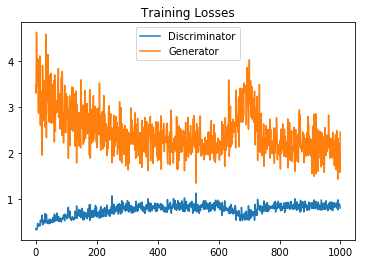

In [12]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Generator samples from training

Below I'm showing the generated images as the network was training, every 10 epochs. With bonus optical illusion!

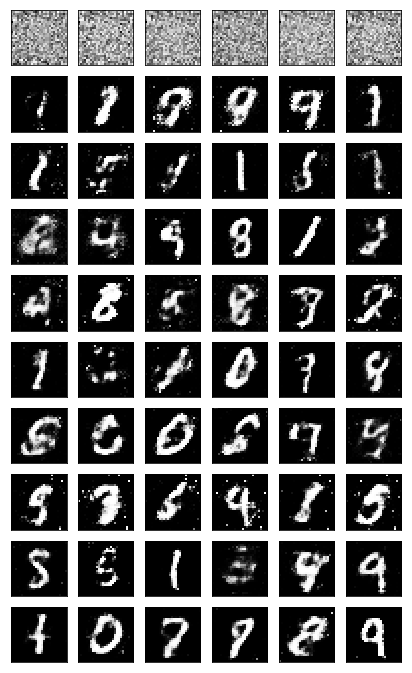

In [13]:
rows, cols = 10, 6
fig, axes = plt.subplots(rows, cols, figsize=(7,12), sharex=True, sharey=True)

for fake_data_batch, ax_row in zip(fake_data[::int(len(fake_data)/rows)], axes):
    for img, ax in zip(fake_data_batch[::int(len(fake_data_batch)/cols)], ax_row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

It starts out as all noise and then it learns to make only the center white and the rest black.

## Sampling from the generator

We just need to pass in a new latent vector $z$ and we'll get new samples!

INFO:tensorflow:Restoring parameters from checkpoints/generator.ckpt


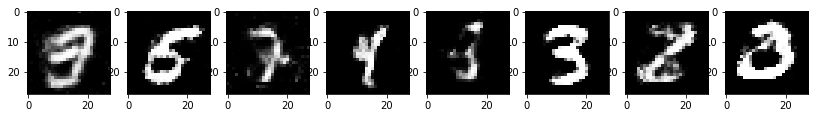

In [14]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1, 1, size=(8, z_size))
    fake_data = sess.run(generator(inputs_z, real_size, reuse=True),
                         feed_dict={inputs_z: sample_z})

# visualize the generated sample
fig, axes = plt.subplots(1, 8, figsize=(14, 1.6))
for img, ax in zip(fake_data, axes):
    ax.imshow(img.reshape((28,28)), cmap='Greys_r')